In [1]:
import numpy as np
import pandas as pd
import pickle

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.subplots import make_subplots
from matplotlib.container import BarContainer


import ipywidgets as widgets
from ipywidgets import interact
from ua_parser import parse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance 
from sklearn import set_config
# set_config(enable_metadata_routing=True)


from xgboost import XGBClassifier
from prince import FAMD, MCA
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from utils.data_processing import transform_ipinfo

In [2]:
data_path = Path("data")
raw_data = pd.read_csv(data_path.joinpath("cybersecurity_attacks.csv"))
df = raw_data.copy()

# Exploratory Data Analysis

## Dataset Presentation

In [3]:
df.shape

(40000, 25)

The dataset provided is composed of 40 000 observations and there are 29 features that describe/give information about each one

In [4]:
df.head(5)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [5]:
df.dtypes.groupby(df.dtypes.astype(str)).size().sort_values(ascending=False)

str        21
int64       3
float64     1
dtype: int64

Of the 25 features we have: <br>
<ol><li>
20 features are of type "string". They are called categorical features as the value they can take can be grouped into categories.
</li>
<li>
4 features are of type "number" (either integer of float)
</li>
<li>
1 feature is related to the date and time of the cyber-attacks.  
</li>
</ol>

In [6]:
df.describe()

,Source Port,Destination Port,Packet Length,Anomaly Scores
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,32970.356450,33150.868650,781.452725,50.113473
std,18560.425604,18574.668842,416.044192,28.853598
min,1027.000000,1024.000000,64.000000,0.000000
25%,16850.750000,17094.750000,420.000000,25.150000
50%,32856.000000,33004.500000,782.000000,50.345000
75%,48928.250000,49287.000000,1143.000000,75.030000
max,65530.000000,65535.000000,1500.000000,100.000000


A quick look at the distribution of the numerical features using the function describe shows that the features are well-distributed. <br>
In fact for each features the mean and median are close to max divided by 2 and the interquartiles are close to the 25 and 75% of the maximum value respectively

In [7]:
temp_data = df.isna().sum().sort_values(ascending=False).to_frame("Missing Values")
temp_data["Percentage"] = (temp_data["Missing Values"] / 40000 * 100).round(2)
temp_data.head(10)

,Missing Values,Percentage
Alerts/Warnings,20067,50.17
IDS/IPS Alerts,20050,50.12
Malware Indicators,20000,50.00
Firewall Logs,19961,49.90
Proxy Information,19851,49.63
Source IP Address,0,0.00
Destination IP Address,0,0.00
Source Port,0,0.00
Timestamp,0,0.00
Traffic Type,0,0.00


There are only 5 features with missing data. <br> 
All of them are related to the detection of the cyber-attack at some point of the process. It is expected because a cyber attack might be more or less sophisticated and might trigger some detectors. <br>
For example a DDoS attack might be easily detected by a trigger looking at the traffic whereas a malware might not trigger the IDS/IPS alerts because it is a new one <br>
and its signature has not been added to the database of existing malwares.

## Types of attack

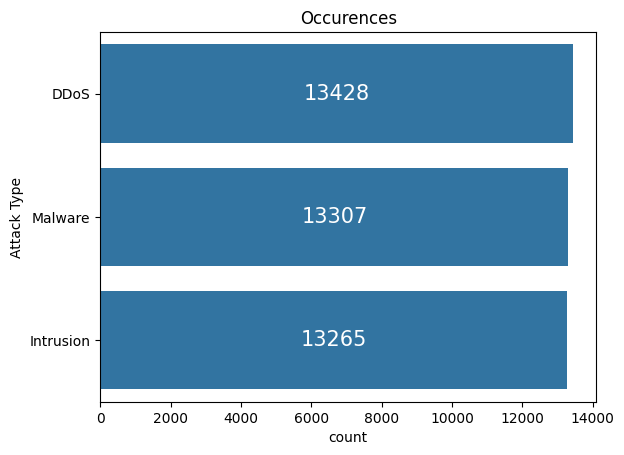

In [8]:
ax = sns.countplot(data=df, y='Attack Type', order=df['Attack Type'].value_counts().index)
container = ax.containers[0]
if isinstance(container, BarContainer):
    ax.bar_label(container, color="white", fontsize=15, label_type='center')
plt.title('Occurences')
plt.show()

## Numerical Features

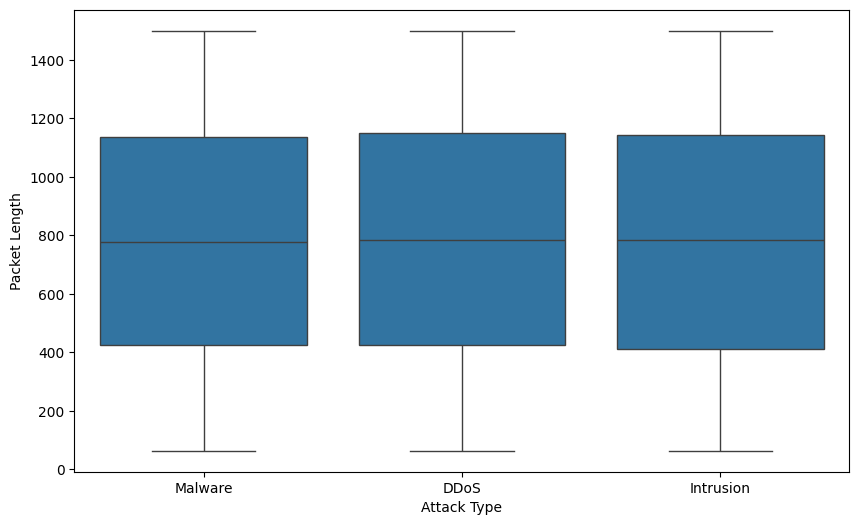

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Attack Type'],y=df['Packet Length'])
plt.show()

<Axes: ylabel='Frequency'>

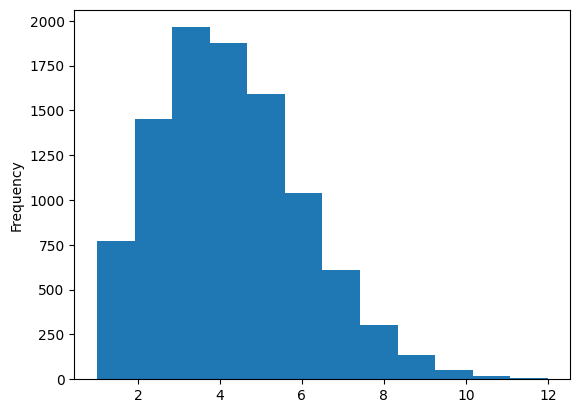

In [10]:
df['Anomaly Scores'].value_counts().plot(kind='hist', bins=12)

Packet Length
1037    47
104     45
1278    45
480     44
855     44
        ..
707     15
470     14
568     14
216     12
940      9
Name: count, Length: 1437, dtype: int64


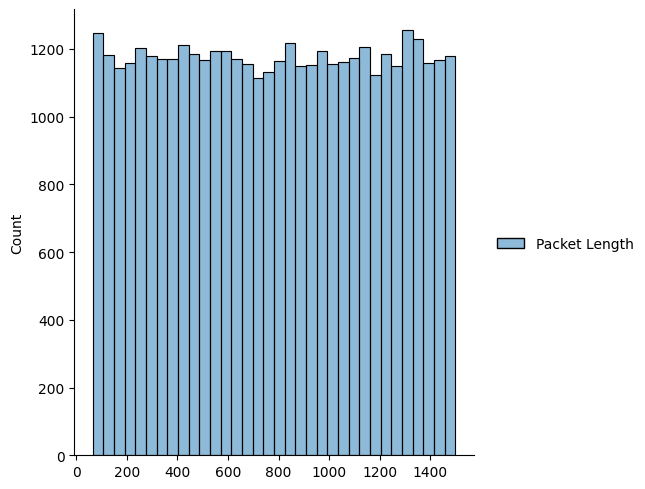

In [11]:
print(df['Packet Length'].value_counts())

sns.displot(df['Packet Length'].to_frame("Packet Length"))

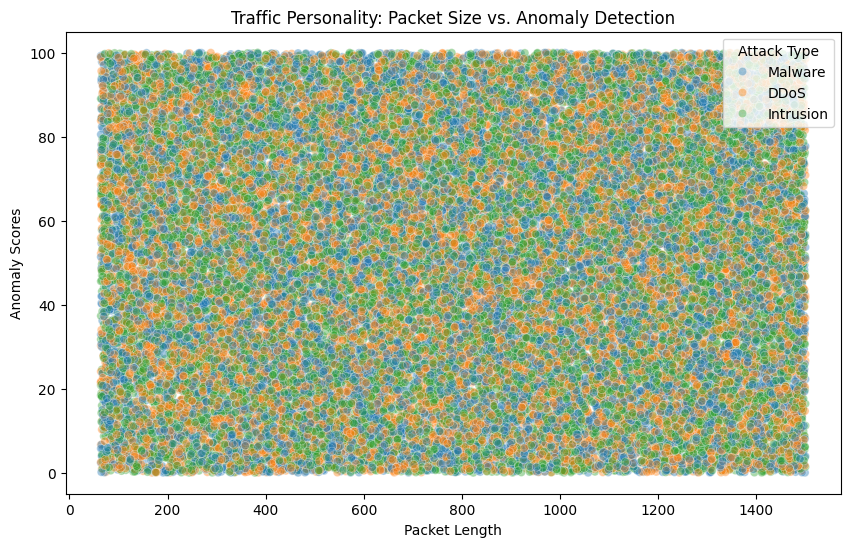

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Packet Length', y='Anomaly Scores', hue='Attack Type', alpha=0.4)
plt.title("Traffic Personality: Packet Size vs. Anomaly Detection")
plt.show()

From the graphic we cannot see clusters depending on the type of attack. The distribution is dense.

In [13]:
def create_displot(data, group_labels):
    return ff.create_distplot(data, group_labels=group_labels, bin_size=25, show_hist=False, show_rug=False)

num_cols = df.select_dtypes(include="number").columns.tolist()
temp_data = df[num_cols].dropna(axis = "columns", how="any")
temp_data = (temp_data - temp_data.mean(axis=0)) / temp_data.std(axis=0)
displot = create_displot([temp_data[x] for x in num_cols], group_labels=[x for x in num_cols])
displot.show()

From the kernel density estimation, we can see the data is fairly distributed among the possible values of each numerical feature. <br> 
In fact the KDE are all close to a uniform distribution ( meaning all values would have the same probability of appearing). <br>

In [14]:
temp_data["Attack Type"] = df["Attack Type"]
num_cols = temp_data.select_dtypes(include="number").columns.tolist()
nb_cols = 4
nb_rows = int(np.ceil(len(num_cols) / nb_cols))
fig = make_subplots(rows=nb_rows, cols=nb_cols)
for i, col in enumerate(num_cols):
    row = i // nb_cols + 1
    col_pos = i % nb_cols + 1
    hist_data = [temp_data[temp_data["Attack Type"] == attack_type][col].values for attack_type in temp_data["Attack Type"].unique()]
    displot = create_displot(hist_data, group_labels=temp_data["Attack Type"].unique())
    for trace in displot.select_traces():
        fig.add_trace(trace, row=row, col=col_pos,)
        fig.update_xaxes(title_text=f"{col} Distribution", row=row, col=col_pos)

fig.update_layout(title="Kernel Density of Numerical Features by Attack Type",
                  width=1600, height=nb_rows*400+200, showlegend=False)
fig.show(renderer="iframe_connected")

Nonetheless if we then look at it by type of attack, we can see there are small variations. 

## Date and time related features

In [15]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Converts text → date/time
df['hour'] = df['Timestamp'].dt.hour # Extracts the hour of the day from the timestamp col.
df['day'] = df['Timestamp'].dt.day # Gets day of month

In [16]:
pd.set_option('display.max_columns', None)
df.groupby('hour')['Attack Type'].value_counts().unstack().T

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Attack Type,,,,,,,,,,,,,,,,,,,,,,,,
DDoS,604,567,559,555,574,547,541,563,570,558,540,580,517,580,537,586,575,548,534,524,605,565,548,551
Intrusion,544,531,548,560,575,567,553,526,564,516,607,510,554,583,538,563,539,576,557,561,562,568,530,533
Malware,557,532,546,537,574,559,539,534,530,565,544,575,517,574,586,571,562,547,574,580,557,549,525,573


In [17]:
pd.reset_option('display.max_columns')
day_attacks = df[(df['hour'] >= 8) & (df['hour'] < 20)].groupby(['Attack Type'] ).size().to_frame("day attacks") # rows between 08:00am  and 19:59pm
night_attacks = df[(df['hour'] < 8) | (df['hour'] >= 20)].groupby(['Attack Type'] ).size().to_frame("night attacks")# attacks between midnight and 7:59 AM or attacks between 8 PM and 11:59 PM selects either of them
dn_df = day_attacks.merge(night_attacks, how='outer', left_index=True, right_index=True)
dn_df["Total"] = dn_df.sum(axis=1)
dn_df = dn_df.T
dn_df["Total"] = dn_df.sum(axis=1)
dn_df

Attack Type,DDoS,Intrusion,Malware,Total
day attacks,6649,6668,6725,20042
night attacks,6779,6597,6582,19958
Total,13428,13265,13307,40000


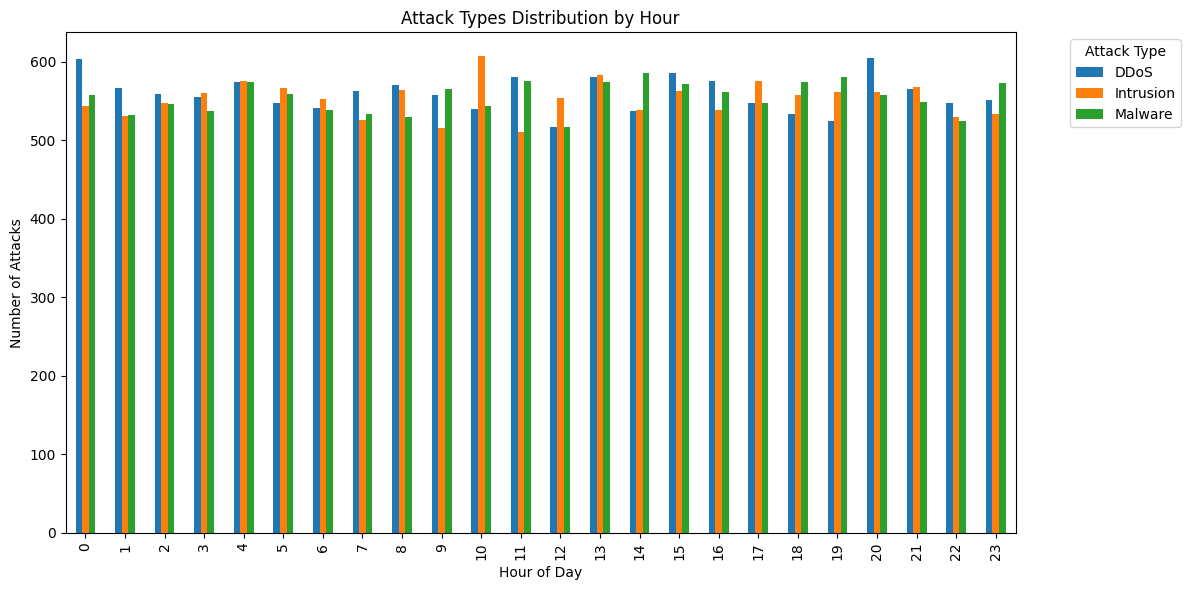

In [18]:
# Group and reshape data
hour_attack = (
    df.groupby('hour')['Attack Type']
    .value_counts()
    .unstack(fill_value=0)
)

# Plot stacked bar chart
hour_attack.plot(
    kind='bar',
    figsize=(12, 6)
)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Attacks')
plt.title('Attack Types Distribution by Hour')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Categorical features

<Axes: >

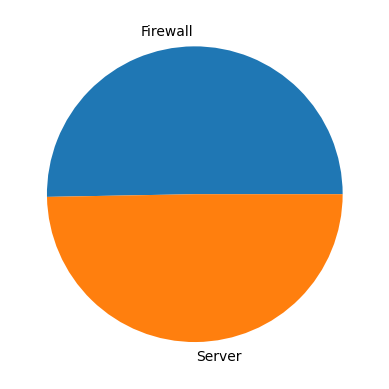

In [19]:
df['Log Source'].value_counts().plot(kind='pie' )

In [20]:
df['Traffic Type'].value_counts()

Traffic Type
DNS     13376
HTTP    13360
FTP     13264
Name: count, dtype: int64

In [21]:
temp_data = df[["Action Taken", "Severity Level","Attack Type"]].groupby(["Action Taken", "Attack Type", "Severity Level",]).size().reset_index(name='Count')
temp_data.T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Action Taken,Blocked,Blocked,Blocked,Blocked,Blocked,Blocked,Blocked,Blocked,Blocked,Ignored,...,Ignored,Logged,Logged,Logged,Logged,Logged,Logged,Logged,Logged,Logged
Attack Type,DDoS,DDoS,DDoS,Intrusion,Intrusion,Intrusion,Malware,Malware,Malware,DDoS,...,Malware,DDoS,DDoS,DDoS,Intrusion,Intrusion,Intrusion,Malware,Malware,Malware
Severity Level,High,Low,Medium,High,Low,Medium,High,Low,Medium,High,...,Medium,High,Low,Medium,High,Low,Medium,High,Low,Medium
Count,1508,1509,1516,1523,1506,1524,1499,1466,1478,1549,...,1482,1466,1441,1529,1469,1417,1425,1457,1435,1556


<Axes: xlabel='Action Taken', ylabel='Count'>

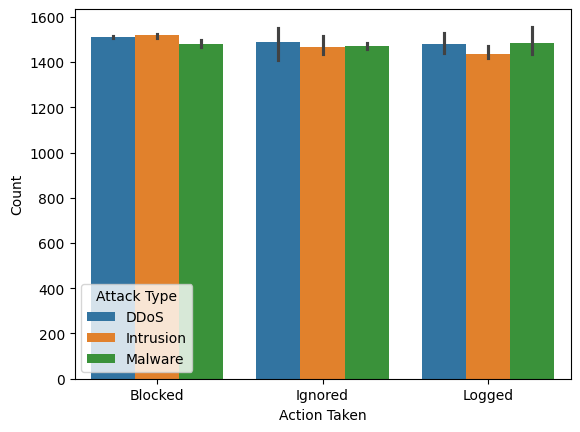

In [22]:
sns.barplot(data=temp_data, x='Action Taken', y='Count', hue='Attack Type')

In [23]:
df['Protocol'].value_counts()

Protocol
ICMP    13429
UDP     13299
TCP     13272
Name: count, dtype: int64

In [24]:
df['Log Source'].value_counts() 

Log Source
Firewall    20116
Server      19884
Name: count, dtype: int64

In [25]:
df['Geo-location Data'].value_counts()

Geo-location Data
Ghaziabad, Meghalaya          16
Kalyan-Dombivli, Jharkhand    15
Ghaziabad, Tripura            14
Ghaziabad, Uttarakhand        14
Ghaziabad, Jharkhand          13
                              ..
Purnia, Uttar Pradesh          1
Cuttack, Sikkim                1
Vadodara, Meghalaya            1
Cuttack, Jharkhand             1
Nagpur, Punjab                 1
Name: count, Length: 8723, dtype: int64

## Device features

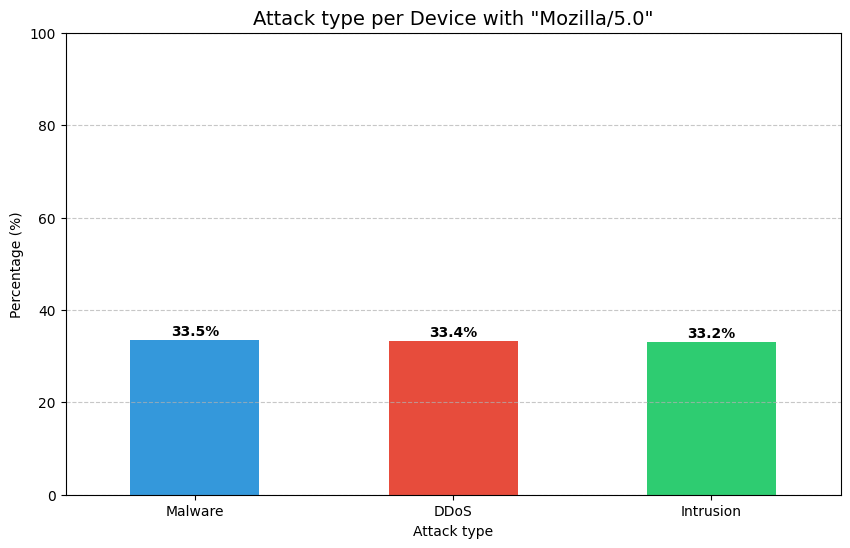

In [26]:
df['Device_Simple'] = df['Device Information'].str.split('(').str[0].str.strip()

df_mozilla = df[df['Device_Simple'] == 'Mozilla/5.0']

mozilla_attack_ratios = df_mozilla['Attack Type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
mozilla_attack_ratios.plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f'])

plt.title('Attack type per Device with "Mozilla/5.0"', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Attack type')
plt.xticks(rotation=0)

for i, v in enumerate(mozilla_attack_ratios):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [27]:
df_opera = df[df['Device Information'].str.contains('Opera|OPR', case=False, na=False)].copy()
df_opera['Filtered'] = df_opera['Device Information'].str.extract(r'((?:Opera|OPR)/[\d\.]+)')
available_versions = sorted(df_opera['Filtered'].dropna().unique())

In [28]:
@interact(version=available_versions)
def afficher_stats_opera(version):
    data_version = df_opera[df_opera['Filtered'] == version]

    if data_version.empty:
        print("No Data for this version")
        return

    ratios = data_version['Attack Type'].value_counts(normalize=True) * 100

    plt.figure(figsize=(10, 5))
    colors = sns.color_palette('magma', len(ratios))

    ratios.plot(kind='bar', color=colors)

    plt.title(f'Attack type per Device wit {version}', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Attack type')
    plt.ylim(0, 100)
    plt.xticks(rotation=0)

    for i, v in enumerate(ratios):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    print(f"Count of attacks for this version : {len(data_version)}")

interactive(children=(Dropdown(description='version', options=('Opera/8.10.', 'Opera/8.11.', 'Opera/8.12.', 'O…

In [29]:


def clean_ua_name(ua_string):
    try:
        ua = parse(str(ua_string))
        ua_browser = getattr(ua.user_agent,"family",None) or "Unknown"
        ua_os = getattr(ua.os,"family",None) or "Unknown"
        return f"{ua_browser} ({ua_os})"
    except Exception:
        return "Unknown"

df["Browser Name"] = df["Device Information"].apply(clean_ua_name)

fig = px.histogram(
    df, 
    x="Browser Name", 
    color="Attack Type", 
    barmode="group",
    title="Browser Name Distribution",
    width=1200, 
    height=600
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [30]:


def get_ua_details(ua_string):
    ua = parse(str(ua_string))
    return {
        "Browser Name": getattr(ua.user_agent,"family",None) or "Unknown",
        "Browser Version": getattr(ua.user_agent,"major",None) or "Unknown"
    }

device_info = df["Device Information"].apply(lambda x: pd.Series(get_ua_details(x)))

chrome_version_data = pd.read_csv("data/chrome_versions.csv", sep=';')
chrome_version_data["release_date"] = pd.to_datetime(chrome_version_data["release_date"], format = "%d/%m/%Y")
chrome_version_data["version"] = chrome_version_data["version"].str.split(".",n = 1).str[0]

temp_data = device_info.reset_index(names=["Original Index"])
temp_data = temp_data[temp_data["Browser Name"] == "Chrome"].copy()

temp_data = temp_data.merge(chrome_version_data, left_on="Browser Version", right_on="version", how="left")
temp_data = temp_data.merge(df["Attack Type"], left_on="Original Index", right_index=True)

version_order = sorted(temp_data["version"].dropna().unique(), key=lambda x: int(x))

fig = px.histogram(
    temp_data, 
    x="version", 
    title="Chrome Version Distribution", 
    color="Attack Type", 
    barmode="group",
    width=1400,
    height=500
)

fig.update_xaxes(type="category", categoryorder="array", categoryarray=version_order)
fig.show()

## Correlation Matrix

Except the data we extract from non-atomic features such as "Timestamps" or "Device Information", it does not look like there are correlations between the features and the type of attack <br>
i.e. the type of attack seems independent of whatever feature we are considering

In [31]:
corr_columns = raw_data.columns.to_list()
corr_columns.remove("Attack Type")
corr_columns.insert(0, "Attack Type")
corr_data, col_name = pd.factorize(raw_data[corr_columns[0]])
corr_data = pd.DataFrame(corr_data, columns=[corr_columns[0]])
for col in corr_columns[1:]:
    temp_data, col_name = pd.factorize(raw_data[col])
    corr_data = pd.concat([corr_data, pd.DataFrame(temp_data, columns=[col])], axis = 1)


heatmap = corr_data.corr()
fig = go.Figure(data=go.Heatmap(
    z=heatmap.values,
    x=heatmap.columns,
    y=heatmap.columns,
    text=heatmap.values,
    texttemplate="%{text:.3f}",
    textfont={"size":8,"color":"rgb(0,0,0)"},
    hoverinfo='text',
    colorscale="tealrose",
    ),
    layout=go.Layout(
        title={"text":"Correlation Heatmap",
               "x" : 0.5,
               "y":0.99,
               "font":{"size":20}},
        height=1200,
        width=1200,
        xaxis={"side":"top"}
    )
)
fig.show()

The correlation matrix above shows that some features are related to each others such as the IP addresses and the Ports. <br>
We could expect such relations between these features because they are related to the network 

In [32]:
temp_data = heatmap["Attack Type"].to_frame().T

fig = px.imshow(temp_data, text_auto=".3f", color_continuous_scale="tealrose")
fig .update_layout(
    title={"text":"Correlation Heatmap",
            "font":{"size":20}},
    xaxis={"side":"top"},
    width=1200,
    )
fig.show()

# Feature Engineering

## Component Analysis

A common thing to improve ML model performance is to select only thoe features that contain the most information.
An algorithm to do so is the Principal Component Analysis (or PCA) which consists on a linear dimensionnality reduction of the total 

In [33]:
RANDOM_STATE = 124

X_orig = raw_data.copy().drop(columns=["Attack Type"])
y_orig = raw_data["Attack Type"].astype("category").cat.codes

ip_columns = ["Int Source IP", "Int Destination IP", "Int Proxy Information", "Global Source IP", "Global Destination IP", "Global Proxy Information"]
X_orig[ip_columns] = transform_ipinfo(raw_data[["Source IP Address", "Destination IP Address","Proxy Information"]])

X_orig = X_orig.drop(columns=["Source IP Address", "Destination IP Address", "Proxy Information", "Int Proxy Information",
                              "Global Source IP", "Global Destination IP", "Global Proxy Information"])

In [ ]:
cat_cols = X_orig.select_dtypes(include=["object","str"]).columns
num_cols = X_orig.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_orig.columns if col not in cat_cols and col not in num_cols]

MAX_CARDINALITY = 100

cardinality_info = {}
for col in cat_cols:
    cardinality = X_orig[col].nunique()
    cardinality_info[col] = cardinality

cardinality_df = pd.DataFrame.from_dict(cardinality_info, orient='index', columns=['Cardinality'])
cardinality_df = cardinality_df.sort_values('Cardinality', ascending=False)

print(f"Categorical features with cardinality:")
print(cardinality_df)

# Filter out high cardinality features
high_card_cols = cardinality_df[cardinality_df['Cardinality'] > MAX_CARDINALITY].index.tolist()
print(f"Removing {len(high_card_cols)} high-cardinality features (>{MAX_CARDINALITY} unique values): {high_card_cols}")

# Update cat_cols to exclude high cardinality features
cat_cols = [col for col in cat_cols if col not in high_card_cols]
cat_cols.extend(num_cols)
print(f"Remaining features: {", ".join(cat_cols)}")

# Drop high cardinality columns from train and test sets
X_lowcard = X_orig.drop(columns=high_card_cols)

Categorical features with cardinality:
                    Cardinality
Payload Data              40000
Timestamp                 39997
User Information          32389
Device Information        32104
Geo-location Data          8723
Severity Level                3
Protocol                      3
Traffic Type                  3
Action Taken                  3
Network Segment               3
Log Source                    2
Attack Signature              2
Packet Type                   2
Malware Indicators            1
Alerts/Warnings               1
Firewall Logs                 1
IDS/IPS Alerts                1
Removing 5 high-cardinality features (>100 unique values): ['Payload Data', 'Timestamp', 'User Information', 'Device Information', 'Geo-location Data']
Remaining features: Protocol, Packet Type, Traffic Type, Malware Indicators, Alerts/Warnings, Attack Signature, Action Taken, Severity Level, Network Segment, Firewall Logs, IDS/IPS Alerts, Log Source, Source Port, Destination Port, 

/tmp/ipykernel_74696/419283367.py:1: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.



In [ ]:
cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
num_cols = X_lowcard.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]

numeric_transformer = Pipeline(
        steps = [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ])

preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_transformer, cat_cols),
            ("num", numeric_transformer, num_cols)
        ]).set_output(transform="pandas")

x_processed = preprocessor.fit_transform(X_lowcard)
cat_cols = x_processed.select_dtypes(include=["object","str"]).columns
num_cols = x_processed.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]
x_processed[cat_cols] = x_processed[cat_cols].astype("category")
x_processed[num_cols] = x_processed[num_cols].astype("float32")

famd = FAMD(n_components=x_processed.shape[1], n_iter=3, random_state=RANDOM_STATE)
famd.fit(x_processed)
famd.eigenvalues_summary.T

/tmp/ipykernel_74696/4121164151.py:1: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.

/tmp/ipykernel_74696/4121164151.py:22: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
eigenvalue,1.019,1.006,1.003,0.996,0.994,0.982,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
% of variance,16.98%,16.77%,16.71%,16.61%,16.56%,16.37%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
% of variance (cumulative),16.98%,33.75%,50.46%,67.06%,83.63%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


In [36]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
variable,,,,,,,,,,,,,,,,,,
num__Source Port,16%,0%,26%,41%,9%,9%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
num__Destination Port,21%,18%,9%,14%,16%,22%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
num__Packet Length,8%,52%,5%,0%,12%,23%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
num__Anomaly Scores,13%,18%,9%,28%,23%,8%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
num__Int Source IP,8%,12%,31%,9%,40%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
num__Int Destination IP,34%,1%,20%,8%,0%,37%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
cat__Action Taken,0%,0%,0%,0%,0%,0%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
cat__Alerts/Warnings,0%,0%,0%,0%,0%,0%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
cat__Attack Signature,0%,0%,0%,0%,0%,0%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


If we look at the contribution of each feature, we notice that the numerical ones are the only ones that contain informations. <br>
Because it is an unexpected results, an MCA analysis is done with the categorical features only. <br>

In [ ]:
cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
X_lowcard = X_lowcard[cat_cols]

cat_cols = X_lowcard.select_dtypes(include=["object","str"]).columns
num_cols = X_lowcard.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]

numeric_transformer = Pipeline(
        steps = [
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

cat_transformer = Pipeline([
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="unknown")),
        ])

preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_transformer, cat_cols),
            ("num", numeric_transformer, num_cols)
        ]).set_output(transform="pandas")

x_processed = preprocessor.fit_transform(X_lowcard)
cat_cols = x_processed.select_dtypes(include=["object","str"]).columns
num_cols = x_processed.select_dtypes(include="number").columns
passthrough_columns = [col for col in X_lowcard.columns if col not in cat_cols and col not in num_cols]
x_processed[cat_cols] = x_processed[cat_cols].astype("category")
x_processed[num_cols] = x_processed[num_cols].astype("float32")
X_train, X_test, y_train, y_test = train_test_split(x_processed, y_orig, test_size=0.2, stratify=y_orig, random_state=RANDOM_STATE)

mca = MCA(n_components=x_processed.shape[1], n_iter=3, random_state=RANDOM_STATE)
xtrain_mca = mca.fit_transform(X_train)
mca.eigenvalues_summary.T

/tmp/ipykernel_74696/2858102755.py:1: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.

/tmp/ipykernel_74696/2858102755.py:4: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 

component,0,1,2,3,4,5,6,7,8,9,10,11
eigenvalue,0.086,0.086,0.085,0.085,0.085,0.084,0.084,0.084,0.083,0.083,0.083,0.082
% of variance,6.09%,6.05%,6.03%,6.02%,5.98%,5.94%,5.92%,5.90%,5.88%,5.86%,5.84%,5.80%
% of variance (cumulative),6.09%,12.14%,18.17%,24.19%,30.16%,36.10%,42.03%,47.93%,53.81%,59.67%,65.52%,71.32%


All categorical features have the same importance meaning there is not one that might be more important than the rest.

# Machine Learning Model

## Baseline Model

In [38]:
df = raw_data.copy()

cols_to_fill = ['Malware Indicators', 'Alerts/Warnings', 'Firewall Logs', 'IDS/IPS Alerts', 'Proxy Information']
for col in cols_to_fill:
    df[col] = df[col].fillna('None')


num_features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
cat_features = ['Timestamp', 'Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators', 'Alerts/Warnings', 
                'Attack Signature', 'Action Taken', 'Severity Level', 'Network Segment', 'Log Source']
text_feature = 'Payload Data'

X = df[num_features + cat_features + [text_feature]]
y = df['Attack Type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),                
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features), 
        ('text', TfidfVectorizer(max_features=50), text_feature)      
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

print("Training the pipeline... Please wait...")
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\n--- Pipeline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training the pipeline... Please wait...

--- Pipeline Results ---
Accuracy Score: 0.3276

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.32      0.38      0.35      2636
   Intrusion       0.35      0.30      0.32      2721
     Malware       0.31      0.30      0.31      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



### Gradient Boosting Classifier

In [39]:
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

df = raw_data.copy()
cols_to_fill = ['Malware Indicators', 'Alerts/Warnings', 'Firewall Logs', 'IDS/IPS Alerts', 'Proxy Information']
for col in cols_to_fill:
    df[col] = df[col].fillna('None')

num_features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
cat_features = ['Timestamp', 'Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators', 'Alerts/Warnings', 
                'Attack Signature', 'Action Taken', 'Severity Level', 'Network Segment', 
                'Log Source']
text_feature = 'Payload Data'

X = df[num_features + cat_features + [text_feature]]
y = df['Attack Type']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('text', TfidfVectorizer(max_features=50, stop_words='english'), text_feature)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dense', FunctionTransformer(to_dense)), # Converts text vectors for the booster
    ('classifier', HistGradientBoostingClassifier(random_state=42, max_iter=200))
])

print("Training the Boosting Pipeline... this may take a moment.")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n--- Model Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Training the Boosting Pipeline... this may take a moment.


/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.




--- Model Results ---
Accuracy Score: 0.3299

Classification Report:
              precision    recall  f1-score   support

        DDoS       0.33      0.44      0.38      2636
   Intrusion       0.34      0.23      0.27      2721
     Malware       0.32      0.32      0.32      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.32      8000
weighted avg       0.33      0.33      0.32      8000



/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.



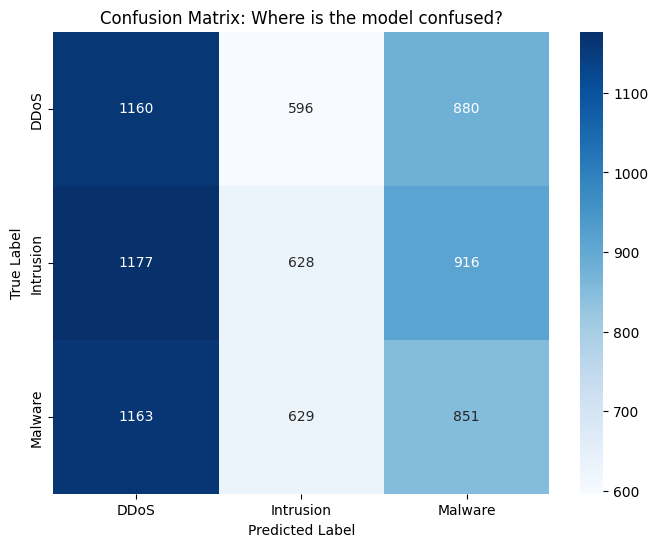

In [40]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where is the model confused?')
plt.show()

The confusion matriw shows that the model tends to predict more DDoS attack whereas it should be relatively even among all the categories. <br>
On the other side the "Intrusion" category" is under predicted. <br>
From this graphic we can calcualte the data shown in the classification in the previous cell:
1. $`\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}`$ <br>
    Looking at the Intrusion type, $\frac{628}{628 + 596 + 629} =0.3389 \approx 34\%$  which is the value found in the previous cell 
2. $`\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}`$ <br>
    Looking at the DDoS type, $\frac{1160}{1160 + 596 + 880} = 0.4401 \approx 44\% $, which is the exact value found in the previous cell


Calculating feature importance (Permutation Importance)...


/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/home/florians/Cours/CyberSecurity_ML/.venv/lib/python3

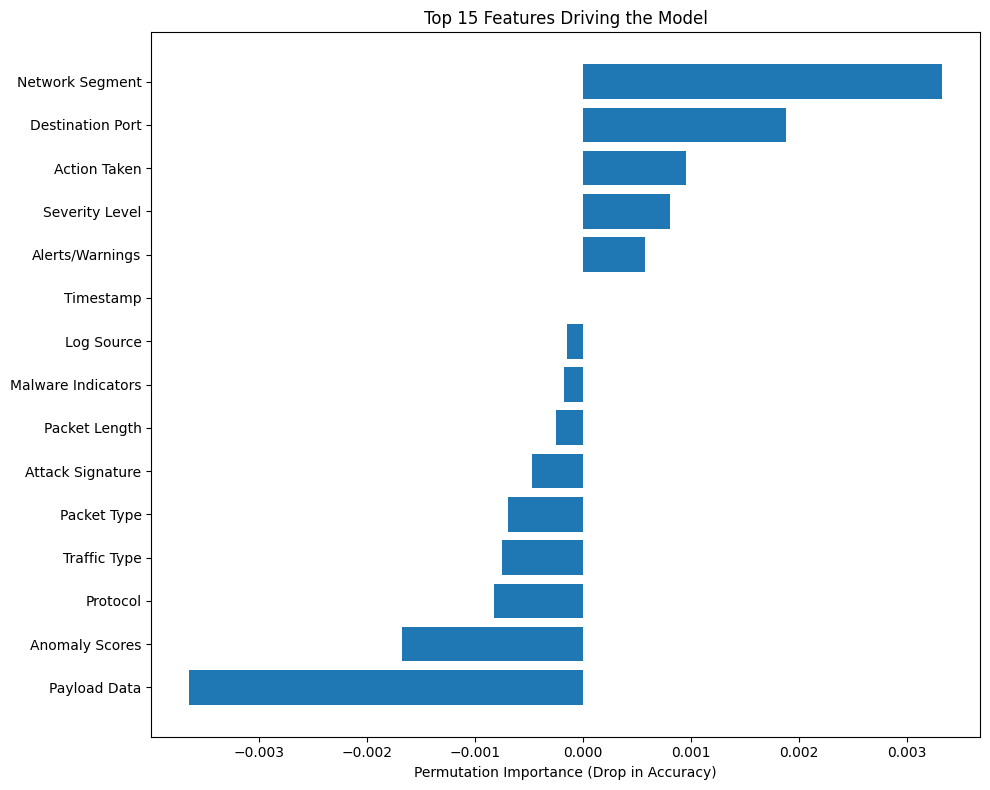

In [44]:
print("Calculating feature importance (Permutation Importance)...")
result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[-15:] # Top 15 features
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Drop in Accuracy)")
plt.title("Top 15 Features Driving the Model")
plt.tight_layout()
plt.show()

Compare to the MCA analyis, the most important features are not only the categorical ones. <br>
Main differences from the analysis is that high-dimensionnality features are used.

In [45]:
with open(data_path.joinpath("final_model.pkl"), "wb") as f:
    pickle.dump(model, f)

In [ ]:
scores = cross_val_score(pipeline, X, y_encoded, cv=5, verbose=1)
print(f"Average Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed:    8.0s remaining:    8.0s


KeyboardInterrupt: 

Our baseline models using RamdomForest and HistGradientBoostingClassifier achieve around 0.33 accuracy, which means it cannot identify patterns and determine what type of cyber attack happened based on the sole dataset without any feature engineering and research of better parameters. <br> 
The confusion matrix and classification reports indicates the model tends to over predict the DDoS category. Some investigation on that result may help to improve the model accuracy.  <br>
Cross-validation results confirm the model's robustness, with consistent performance across folds.